In [226]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition
from scipy.stats import shapiro
import matplotlib.pyplot as plt 
import scipy.stats as st
from scipy.stats import bartlett
import plotly.express as px
import matplotlib.patches as mpatches

### Récupération des données, puis traitement

In [227]:
exp_mor = pd.read_csv('exp_mor.csv')
sql_pays = pd.read_csv('sql-pays.csv')
pib = pd.read_csv('pib.csv')
ll = pd.read_csv('ll.txt', sep='  ')
pays_temp = pd.read_csv('pays_temp.csv')
population = pd.read_csv('population.csv')

<ipython-input-227-48add3a37052>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ll = pd.read_csv('ll.txt', sep='  ')


### Données des populations des pays

In [228]:
population.dropna(inplace=True)

In [229]:
population

Series Name  Series Code         Country Name Country Code  \
0    Population, total  SP.POP.TOTL          Afghanistan          AFG   
1    Population, total  SP.POP.TOTL              Albanie          ALB   
2    Population, total  SP.POP.TOTL              Algérie          DZA   
3    Population, total  SP.POP.TOTL    Samoa américaines          ASM   
4    Population, total  SP.POP.TOTL              Andorre          AND   
..                 ...          ...                  ...          ...   
212  Population, total  SP.POP.TOTL    Îles Vierges (EU)          VIR   
213  Population, total  SP.POP.TOTL  Cisjordanie et Gaza          PSE   
214  Population, total  SP.POP.TOTL       Yémen, Rép. du          YEM   
215  Population, total  SP.POP.TOTL               Zambie          ZMB   
216  Population, total  SP.POP.TOTL             Zimbabwe          ZWE   

    2019 [YR2019]  
0        38041757  
1         2854191  
2        43053054  
3           55312  
4           77146  
..            ...  
212        106669  
213       4685306  
214      29161922  
215      17861034  
216      14645473  

[217 rows x 5 columns]

In [230]:
population = population[['Country Code','2019 [YR2019]']]
population.rename(columns={'2019 [YR2019]':'Population', 'Country Code':'COU'}, inplace=True)
#population.Population = population.Population*1000
population.head()

C:\Users\denis\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


COU Population
0  AFG   38041757
1  ALB    2854191
2  DZA   43053054
3  ASM      55312
4  AND      77146

In [231]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 216
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COU         217 non-null    object
 1   Population  217 non-null    object
dtypes: object(2)
memory usage: 5.1+ KB


### Données concernant la latitude et la longitude de chaque pays

In [232]:
ll.head()

Pays Latitude Longitude
0        Afghanistan  34°28'N   69°11'E
1            Albanie  41°18'N   19°49'E
2            Algérie  36°42'N   03°08'E
3  Samoa américaines  14°16'S  170°43'W
4            Andorre  42°31'N   01°32'E

#### Afin de pouvoir convertir les latitudes et longitudes en variables numériques, nous allons rendre les variables suivies de S et W négatives pour les latitudes et longitudes respectivement.

In [233]:
ll['latitude(°)'] = ll.Latitude.apply(lambda x: x.split("'")[0])
ll['d_lat'] = ll.Latitude.apply(lambda x: x.split("'")[1])
ll['longitude(°)'] = ll.Longitude.apply(lambda x: x.split("'")[0])
ll['d_long'] = ll.Longitude.apply(lambda x: x.split("'")[1])

In [234]:
ll['latitude(°)'] = ll['latitude(°)'].str.replace('°','.')
ll['longitude(°)'] = ll['longitude(°)'].str.replace('°','.')

In [235]:
ll['latitude(°)'] = ll['latitude(°)'].astype(float)
ll['longitude(°)'] = ll['longitude(°)'].astype(float)

In [236]:
ll.head()

Pays Latitude Longitude  latitude(°) d_lat  longitude(°)  \
0        Afghanistan  34°28'N   69°11'E        34.28     N         69.11   
1            Albanie  41°18'N   19°49'E        41.18     N         19.49   
2            Algérie  36°42'N   03°08'E        36.42     N          3.08   
3  Samoa américaines  14°16'S  170°43'W        14.16     S        170.43   
4            Andorre  42°31'N   01°32'E        42.31     N          1.32   

  d_long  
0      E  
1      E  
2      E  
3      W  
4      E

In [237]:
for i in range(len(ll)):
    if ll['d_lat'][i] == 'S':
        ll['latitude(°)'][i] = - ll['latitude(°)'][i]

<ipython-input-237-cb446483319b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ll['latitude(°)'][i] = - ll['latitude(°)'][i]


In [238]:
for i in range(len(ll)):
    if ll['d_long'][i] == 'W':
        ll['longitude(°)'][i] = - ll['longitude(°)'][i]

<ipython-input-238-7860bee172c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ll['longitude(°)'][i] = - ll['longitude(°)'][i]


In [239]:
ll = ll[['Pays', 'latitude(°)']]

In [240]:
ll.head()

Pays  latitude(°)
0        Afghanistan        34.28
1            Albanie        41.18
2            Algérie        36.42
3  Samoa américaines       -14.16
4            Andorre        42.31

### Données concernant les décès prématurés par pays liées à la hausse des températures 

In [241]:
dec_pre = exp_mor[exp_mor.VAR == 'MOR_CAP']

In [242]:
dec_pre = dec_pre[['COU', 'Pays', 'Value']]
dec_pre.rename(columns={'Value':'Décès prématurés(1MHAB)'},inplace=True)

In [243]:
dec_pre.head()

COU         Pays  Décès prématurés(1MHAB)
0  AUS    Australie                   57.871
2  AFG  Afghanistan                   27.718
4  ALB      Albanie                    0.355
6  DZA      Algérie                   76.747
8  AND      Andorre                    0.012

### Données sur le PIB de chaque pays

In [244]:
pib = pib[['Code zone (ISO3)', 'Valeur']]
pib.rename(columns={'Code zone (ISO3)':'COU', 'Valeur':'PIB(USGDP)'}, inplace=True)

In [245]:
pib.head()

COU    PIB(USGDP)
0  AFG    469.919090
1  ZAF   6001.389576
2  ALB   5303.197823
3  DZA   3975.510381
4  DEU  46231.563366

### Données sur les températures de chaque pays

In [246]:
pays_temp.drop('Unnamed: 0', axis=1, inplace=True)

In [247]:
pays_temp = pays_temp[['Pays', 'tmin', 'tmax']]
pays_temp.head()

Pays  tmin  tmax
0          Mali  19.4  34.6
1  Burkina Faso  22.9  33.9
2       Senegal  23.3  32.8
3        Tuvalu  27.1  29.6
4      Djibouti  22.7  34.1

In [248]:
pays_temp.rename(columns={'Pays':'Country'}, inplace=True)

### Implémentation du code ISO3 pour le dataframe 'pays_temp'

In [249]:
sql_pays= sql_pays[['ISO3', 'Country']]
sql_pays.rename(columns={'ISO3':'COU'}, inplace=True)

In [250]:
pays_temp = pays_temp.merge(sql_pays, on='Country', how='outer')

In [251]:
pays_temp[pays_temp.isna().COU]

Country  tmin  tmax  COU
15                                         South Sudan  25.0  31.8  NaN
34                                       Côte d’Ivoire  24.3  30.3  NaN
36                    Micronesia (Federated States of)  25.4  27.7  NaN
48                  Venezuela (Bolivarian Republic of)  24.3  27.9  NaN
60                            Central African Republic  23.0  28.4  NaN
72                                               Congo  22.4  26.8  NaN
76                                            Viet Nam  18.4  28.5  NaN
80                    Democratic Republic of the Congo  22.5  25.6  NaN
93                                          Cabo Verde  19.6  26.3  NaN
98                         United Republic of Tanzania  20.1  24.8  NaN
100                                              Libya  11.5  32.0  NaN
112                   Bolivia (Plurinational State of)  16.2  24.0  NaN
113                                           Eswatini  14.4  25.8  NaN
128                         Iran (Islamic Republic of)  -0.1  31.3  NaN
149                                             Serbia  -4.8  23.9  NaN
154                                    North Macedonia  -3.9  22.9  NaN
164                                         Montenegro  -4.8  21.6  NaN
166  United Kingdom of Great Britain and Northern I...   0.1  17.2  NaN
169                                            Czechia  -5.8  21.2  NaN
173                           United States of America  -6.9  21.4  NaN

#### Nous avons ici des pays dont la variable 'COU' est nulles, il suffit simplement de les implémenter manuellement

In [252]:
pays_temp.loc[15, 'COU'] = 'SSD'
pays_temp.loc[34, 'COU'] = 'CIV'
pays_temp.loc[36, 'COU'] = 'FSM'
pays_temp.loc[48, 'COU'] = 'VEN'
pays_temp.loc[60, 'COU'] = 'CAF'
pays_temp.loc[72, 'COU'] = 'COG'
pays_temp.loc[76, 'COU'] = 'VNM'
pays_temp.loc[80, 'COU'] = 'COD'
pays_temp.loc[93, 'COU'] = 'CPV'
pays_temp.loc[98, 'COU'] = 'TZA'
pays_temp.loc[100, 'COU'] = 'LBY'
pays_temp.loc[112, 'COU'] = 'BOL'
pays_temp.loc[113, 'COU'] = 'SWZ'
pays_temp.loc[128, 'COU'] = 'IRN'
pays_temp.loc[149, 'COU'] = 'SRB'
pays_temp.loc[154, 'COU'] = 'MKD'
pays_temp.loc[164, 'COU'] = 'MNE'
pays_temp.loc[166, 'COU'] = 'GBR'
pays_temp.loc[169, 'COU'] = 'CZE'
pays_temp.loc[173, 'COU'] = 'USA'

In [253]:
pays_temp.dropna(inplace=True)

In [254]:
pays_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 195
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  196 non-null    object 
 1   tmin     196 non-null    float64
 2   tmax     196 non-null    float64
 3   COU      196 non-null    object 
dtypes: float64(2), object(2)
memory usage: 7.7+ KB


### Création du dataframe final pour notre analyse

In [255]:
df = dec_pre.merge(ll, on='Pays')
df1 = df.merge(pib, on='COU')
df2 = df1.merge(population, on='COU')
data_df = df2.merge(pays_temp, on='COU')

In [256]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 0 to 188
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   COU                      189 non-null    object 
 1   Pays                     189 non-null    object 
 2   Décès prématurés(1MHAB)  189 non-null    float64
 3   latitude(°)              189 non-null    float64
 4   PIB(USGDP)               189 non-null    float64
 5   Population               189 non-null    object 
 6   Country                  189 non-null    object 
 7   tmin                     189 non-null    float64
 8   tmax                     189 non-null    float64
dtypes: float64(5), object(4)
memory usage: 14.8+ KB


In [257]:
data_df[data_df.Population=='..']

COU      Pays  Décès prématurés(1MHAB)  latitude(°)  PIB(USGDP)  \
57  ERI  Érythrée                  209.104        15.19  566.711679   

   Population  Country  tmin  tmax  
57         ..  Eritrea  20.3  31.1

In [258]:
data_df.loc[57, 'Population'] = '6081000'

In [259]:
data_df.Population = data_df.Population.astype(int)

In [260]:
data_df['Décès prématurés par année'] = np.ceil(data_df['Décès prématurés(1MHAB)'] * data_df.Population / 1000000)

In [261]:
data_df.head()

COU         Pays  Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)  \
0  AUS    Australie                   57.871       -35.15  54763.202388   
1  AFG  Afghanistan                   27.718        34.28    469.919090   
2  ALB      Albanie                    0.355        41.18   5303.197823   
3  DZA      Algérie                   76.747        36.42   3975.510381   
4  AND      Andorre                    0.012        42.31  40887.421647   

   Population      Country  tmin  tmax  Décès prématurés par année  
0    25365745    Australia  13.2  29.9                      1468.0  
1    38041757  Afghanistan  -4.0  27.1                      1055.0  
2     2854191      Albania  -0.6  23.6                         2.0  
3    43053054      Algeria  10.9  34.1                      3305.0  
4       77146      Andorra  -2.1  20.6                         1.0

In [262]:
data_df['Décès prématurés par année'] = data_df['Décès prématurés par année'].astype(int)

In [263]:
data = data_df.copy()

In [264]:
data.drop(columns=['COU', 'Pays', 'Population', 'Décès prématurés par année'], inplace=True)
data.set_index('Country', inplace=True)
data

Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)  tmin  tmax
Country                                                                    
Australia                     57.871       -35.15  54763.202388  13.2  29.9
Afghanistan                   27.718        34.28    469.919090  -4.0  27.1
Albania                        0.355        41.18   5303.197823  -0.6  23.6
Algeria                       76.747        36.42   3975.510381  10.9  34.1
Andorra                        0.012        42.31  40887.421647  -2.1  20.6
...                              ...          ...           ...   ...   ...
Tunisia                       27.747        36.50   3317.515276   8.7  32.1
Viet Nam                      44.142        21.05   2715.275874  18.4  28.5
Yemen                         95.649        15.33    855.066811  17.9  29.1
Montenegro                     0.388        42.42   8825.344514  -4.8  21.6
South Sudan                  100.865         7.51    448.355293  25.0  31.8

[189 rows x 5 columns]

### Clustering hiérarchique afin de grouper les pays en plusieurs clusters

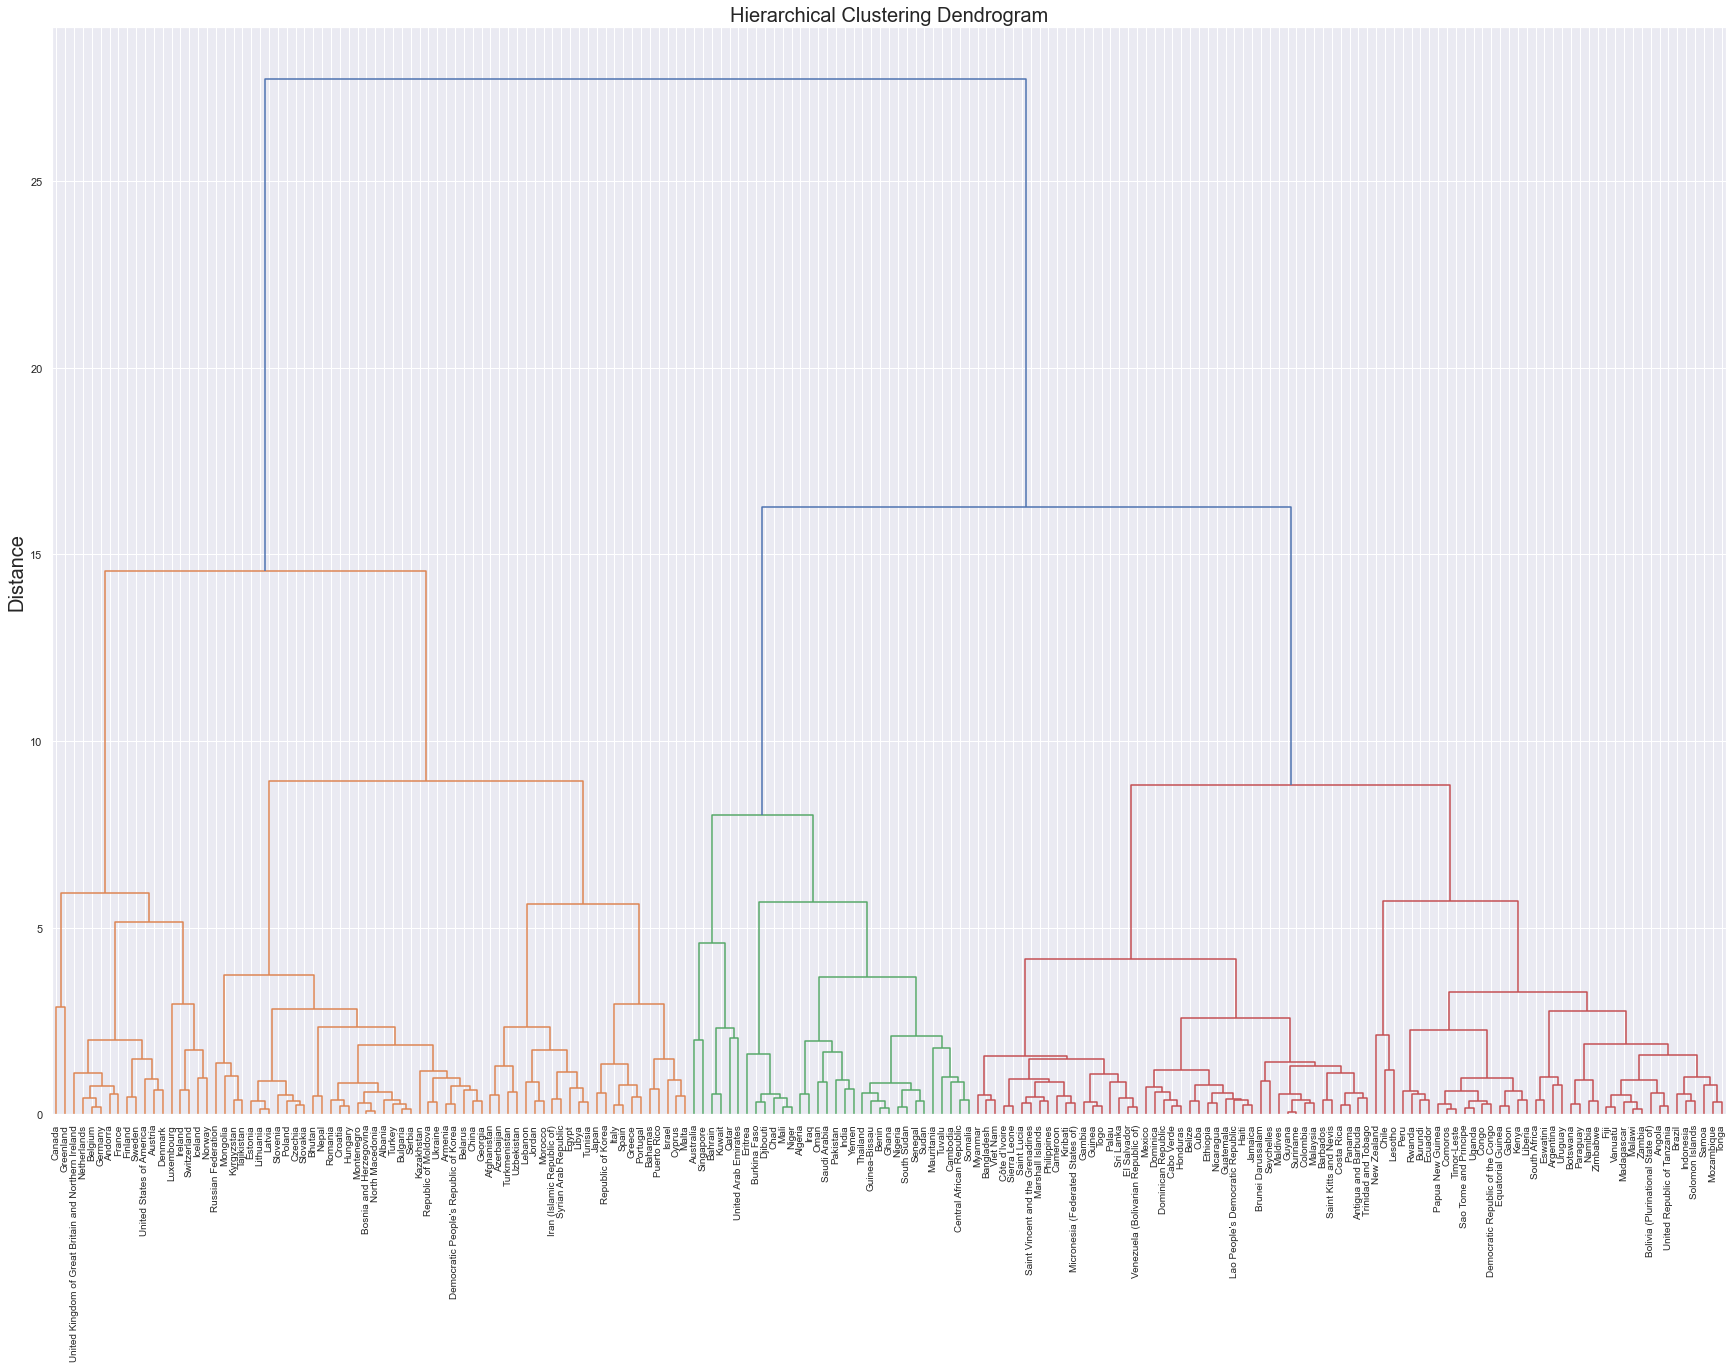

In [265]:
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')


# Affichage du dendrogramme
fig =plt.figure(figsize=(30,20))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.ylabel('Distance', fontsize=20)
dendrogram(Z, labels = names, leaf_font_size=10, color_threshold=15)
plt.savefig("p8_graphic/dendogramme.png")
plt.show()

### Un bref aperçu du dendrogramme nous permet de choisir le bon nombre de clusters, à savoir 3 dans notre cas. Il suffit de couper au niveau de la branche la plus longue.

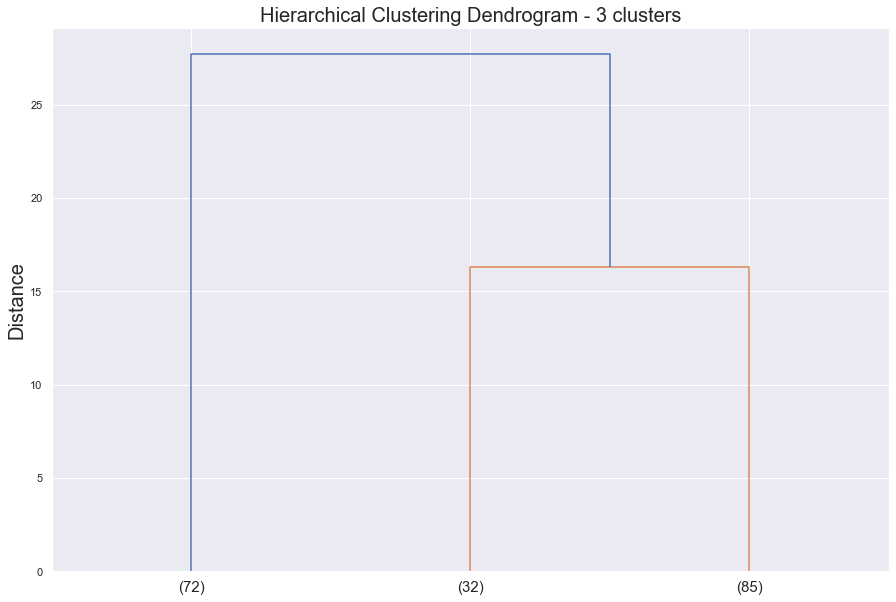

In [266]:
fig = plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram - 3 clusters', fontsize=20)
plt.ylabel('Distance', fontsize=20)

dendrogram(Z, labels = names, p=3, truncate_mode='lastp', leaf_font_size=15)
plt.savefig("p8_graphic/dendogramme_3clusters.png")
plt.show()

In [267]:
clusters = fcluster(Z, 3, criterion='maxclust')

#Index trié des groupes
idg = np.argsort(clusters)

#Affichage des pays selon leurs groupes
clusters_df = pd.DataFrame(names[idg], clusters[idg]).reset_index()
clusters_df = clusters_df.rename(columns={'index':'cluster'})

In [268]:
data = data.merge(clusters_df, on='Country')
data_df = data_df.merge(clusters_df, on='Country')

In [269]:
c = data.groupby('cluster').mean()
c

Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)       tmin  \
cluster                                                                  
1                       6.755833    43.495139  24859.193480  -4.375000   
2                     105.603312    12.790938  11445.565892  19.018750   
3                      24.167671    -0.601294   6205.729039  20.478824   

              tmax  
cluster             
1        22.926389  
2        32.684375  
3        26.723529

In [270]:
data.iloc[:, :6]

Country  Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)  tmin  \
0      Australia                   57.871       -35.15  54763.202388  13.2   
1    Afghanistan                   27.718        34.28    469.919090  -4.0   
2        Albania                    0.355        41.18   5303.197823  -0.6   
3        Algeria                   76.747        36.42   3975.510381  10.9   
4        Andorra                    0.012        42.31  40887.421647  -2.1   
..           ...                      ...          ...           ...   ...   
184      Tunisia                   27.747        36.50   3317.515276   8.7   
185     Viet Nam                   44.142        21.05   2715.275874  18.4   
186        Yemen                   95.649        15.33    855.066811  17.9   
187   Montenegro                    0.388        42.42   8825.344514  -4.8   
188  South Sudan                  100.865         7.51    448.355293  25.0   

     tmax  
0    29.9  
1    27.1  
2    23.6  
3    34.1  
4    20.6  
..    ...  
184  32.1  
185  28.5  
186  29.1  
187  21.6  
188  31.8  

[189 rows x 6 columns]

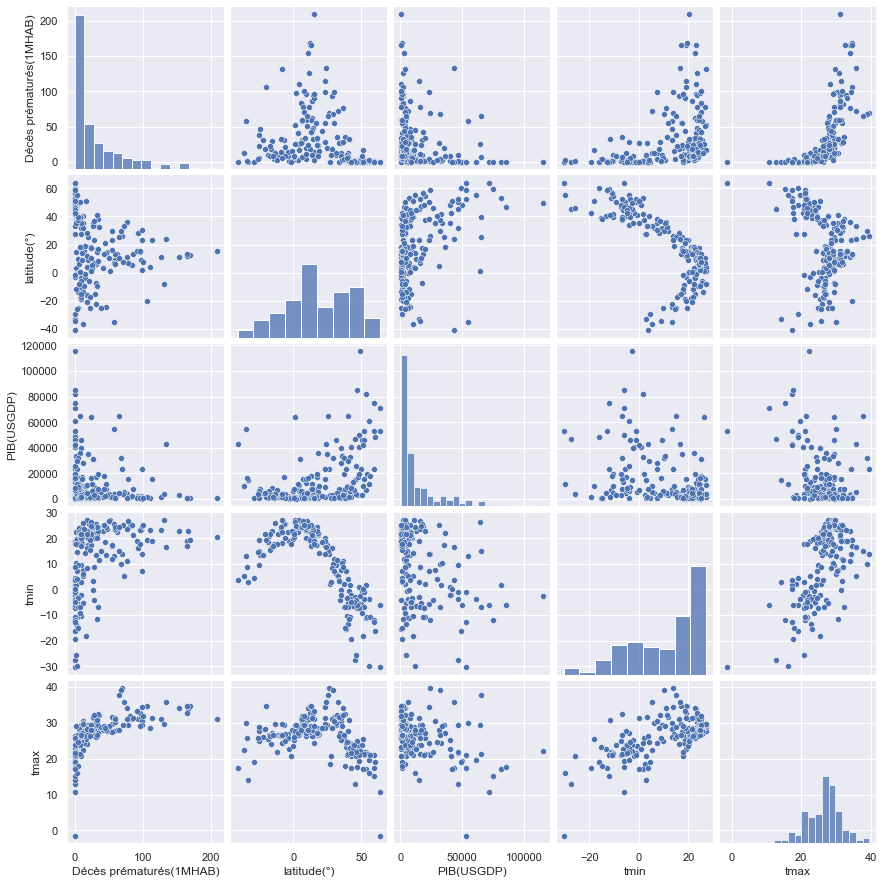

In [271]:
#Visualisation exploratoire des 6 variables quantitatives
sns.pairplot(data.iloc[:, :6])

plt.savefig("p8_graphic/pairplot.png")
plt.show()

In [272]:
data.sort_values('PIB(USGDP)', ascending=False)

Country  Décès prématurés(1MHAB)  latitude(°)  \
85                 Luxembourg                    0.298        49.37   
143               Switzerland                    0.174        46.57   
71                    Ireland                    0.000        53.21   
121                    Norway                    0.047        59.55   
77                    Iceland                    0.000        64.10   
..                        ...                      ...          ...   
30   Central African Republic                  110.890         4.23   
188               South Sudan                  100.865         7.51   
102                    Malawi                    4.341       -14.00   
27                    Burundi                    0.817        -3.16   
152                   Somalia                   98.105         2.02   

        PIB(USGDP)  tmin  tmax  cluster  
85   115480.867570  -2.7  22.1        1  
143   85134.954826  -6.0  17.7        1  
71    81636.578555   1.8  17.2        1  
121   74985.515257 -12.0  15.2        1  
77    71344.613669  -6.0  10.8        1  
..             ...   ...   ...      ...  
30      467.907246  23.0  28.4        2  
188     448.355293  25.0  31.8        2  
102     434.772494  17.7  26.6        3  
27      260.381563  18.9  22.6        3  
152     105.310682  24.8  29.3        2  

[189 rows x 7 columns]

In [273]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = st.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

In [274]:
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})

In [275]:
tc = data.drop(['Country', 'cluster'],axis=1)

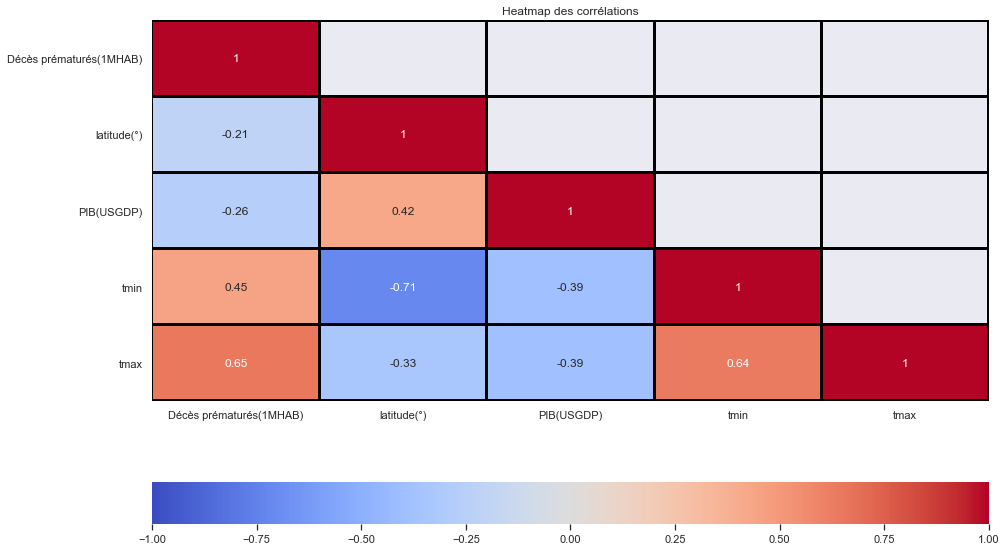

In [276]:
# Plotting with significance filter
corr = tc.corr()                           # get correlation
p_values = corr_sig(tc)                     # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr
plot_cor_matrix(corr, mask) 
plt.title('Heatmap des corrélations')

plt.savefig("p8_graphic/heatmap.png")
plt.show()

In [277]:
[p_values]

[array([[0.00000000e+00, 4.30008785e-03, 2.60338329e-04, 1.21423469e-10,
         1.94623036e-24],
        [4.30008785e-03, 0.00000000e+00, 1.32662308e-09, 1.03537882e-30,
         3.15783954e-06],
        [2.60338329e-04, 1.32662308e-09, 0.00000000e+00, 3.68848748e-08,
         3.00774729e-08],
        [1.21423469e-10, 1.03537882e-30, 3.68848748e-08, 0.00000000e+00,
         5.40322843e-23],
        [1.94623036e-24, 3.15783954e-06, 3.00774729e-08, 5.40322843e-23,
         0.00000000e+00]])]

### Cette heatmap nous permet de nous rendre compte des variables qui sont corrélées entre elles. Les valeurs affichées sur le tableau représente le coefficient de Pearson dont la corrélation est significative (p-value<5%). Nous pouvons déduire grâce à cela que:
### Le PIB est anti-corrélée à tous les variables sauf la latitude. Cela implique alors que plus un pays est riche, plus il sera situé vers le nord du globe, et par conséquent verra sa température moins grande, et sera donc moins à risque face aux fortes températures.
### Plus un pays a de températures élevés, plus il s'expose aux riques liées aux fortes températures, en plus d'être moins riche.


In [278]:
data_cl1 = data[data.cluster == 1]
data_cl2 = data[data.cluster == 3]
data_cl3 = data[data.cluster == 2]

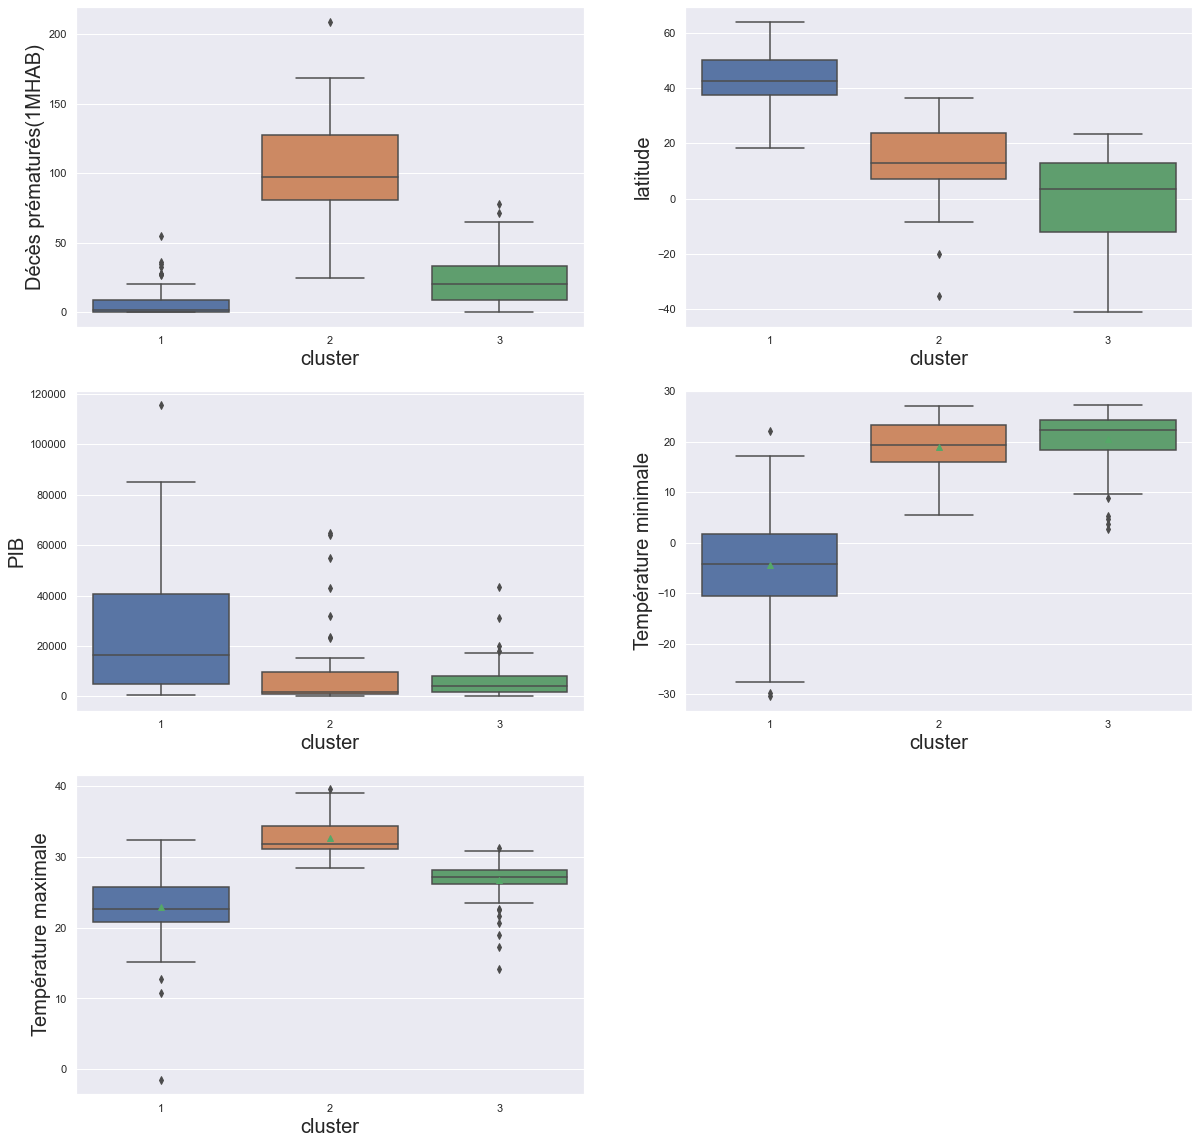

In [279]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les clusters
plt.figure(figsize=(20, 20))
sns.set()

plt.subplot(321)
sns.boxplot(data=data, x='cluster', y='Décès prématurés(1MHAB)')
plt.xlabel('cluster', fontsize=20)
plt.ylabel('Décès prématurés(1MHAB)', fontsize=20)

plt.subplot(322)
sns.boxplot(data=data, x='cluster', y='latitude(°)')
plt.xlabel('cluster', fontsize=20)
plt.ylabel('latitude', fontsize=20)

#plt.subplot(336)
#sns.boxplot(data=data, x='cluster', y='longitude(°)',showmeans=True)

plt.subplot(323)
sns.boxplot(data=data, x='cluster', y='PIB(USGDP)')
plt.xlabel('cluster', fontsize=20)
plt.ylabel('PIB', fontsize=20)

#plt.subplot(334)
#sns.boxplot(data=data, x='cluster', y='Variation_temp',showmeans=True)

plt.subplot(324)
sns.boxplot(data=data, x='cluster', y='tmin',showmeans=True)
plt.xlabel('cluster', fontsize=20)
plt.ylabel('Température minimale', fontsize=20)

plt.subplot(325)
sns.boxplot(data=data, x='cluster', y='tmax',showmeans=True)
plt.xlabel('cluster', fontsize=20)
plt.ylabel('Température maximale', fontsize=20)

#plt.subplot(336)
#sns.boxplot(data=data, x='cluster', y='température moyenne(°C)',showmeans=True)

plt.savefig('p8_graphic/boxplot.png')
plt.show()

### Ces boxplot permet de définir explicitement les 3 clusters à savoir que:
### 1) Le cluster 1 correspond aux pays riches, situés au nord du globe, et sont les moins affectés par la hausse de la température, car il y fait aussi froid
### 2) Le cluster 2 correspond aux pays pauvre, situés vers la zone équatoriale du globe, et sont les plus affectés par la hausse de la température. C'est dans ces zones qu'il y fait le plus chaud
### 3) Le cluster 3 correspond aux pays pauvres, situés vers le sud du globe, et ne sont pas si affectés que cela par la hausse de la température, bien qu'il y fasse chaud la majorité du temps
### Nous cherchons à déterminer quels sont les pays les plus affectés par le réchauffement climatique, il est alors évident que nous allons continuer notre analyse avec le cluster 2 affiché ci-dessous:

In [280]:
data_cl3

Country  Décès prématurés(1MHAB)  latitude(°)  \
0                   Australia                   57.871       -35.15   
3                     Algeria                   76.747        36.42   
11                    Bahrain                   68.733        26.10   
24                      Benin                   81.501         6.23   
26               Burkina Faso                  165.721        12.15   
30   Central African Republic                  110.890         4.23   
31                       Chad                  165.317        12.10   
33                   Cambodia                  125.876        11.33   
49                   Djibouti                  153.506        11.08   
57                    Eritrea                  209.104        15.19   
64                      Ghana                   83.446         5.35   
72              Guinea-Bissau                   77.323        11.45   
74                      India                   93.120        28.37   
86                       Iraq                   72.472        33.20   
89                     Kuwait                   67.371        29.30   
107                      Mali                  168.774        12.34   
109                Mauritania                  106.509       -20.10   
112                     Niger                  165.037        13.27   
119                   Nigeria                   96.700         9.05   
123                      Oman                  114.109        23.37   
124                  Pakistan                   99.098        30.26   
126                     Qatar                   65.255        25.15   
140                   Senegal                   95.173        14.34   
141                 Singapore                   24.748         1.16   
146              Saudi Arabia                   98.270        23.53   
152                   Somalia                   98.105         2.02   
160                  Thailand                   85.901        13.45   
164      United Arab Emirates                  133.601        24.28   
170                    Tuvalu                  131.560        -8.31   
174                     Sudan                   90.954        15.31   
186                     Yemen                   95.649        15.33   
188               South Sudan                  100.865         7.51   

       PIB(USGDP)  tmin  tmax  cluster  
0    54763.202388  13.2  29.9        2  
3     3975.510381  10.9  34.1        2  
11   23503.977127  13.8  39.6        2  
24    1220.492825  24.9  31.9        2  
26     786.895614  22.9  33.9        2  
30     467.907246  23.0  28.4        2  
31     706.825833  18.9  32.7        2  
33    1643.641451  23.3  31.0        2  
49    3252.320409  22.7  34.1        2  
57     566.711679  20.3  31.1        2  
64    2202.629207  25.0  31.1        2  
72     688.351615  23.4  31.1        2  
74    2116.177386  16.3  31.1        2  
86    5729.677358   5.4  35.8        2  
89   31999.271891  10.0  39.0        2  
107    886.794271  19.4  34.6        2  
109   1677.917728  19.1  34.5        2  
112    554.579943  17.1  34.6        2  
119   2361.206967  23.2  31.5        2  
123  15343.062004  18.9  31.4        2  
124   1186.692080   7.3  30.4        2  
126  64781.733197  15.1  37.8        2  
140   1452.134664  23.3  32.8        2  
141  64102.737611  26.1  29.3        2  
146  23139.802114  13.7  34.3        2  
152    105.310682  24.8  29.3        2  
160   7784.739080  21.4  31.2        2  
164  43103.323058  16.5  35.7        2  
170   4036.000516  27.1  29.6        2  
174    815.060101  18.7  33.2        2  
186    855.066811  17.9  29.1        2  
188    448.355293  25.0  31.8        2

In [281]:
data_cl3.set_index('Country', inplace=True)
data_cl3.drop('cluster', axis=1, inplace=True)

C:\Users\denis\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Analyse des composantes principales
### Cette analyse nous permettra de visualiser concrètement les relations entre les différentes variables
### Nous pouvons également de trouver le plan de projection limitant le plus la perte d'information

In [282]:
# choix du nombre de composantes à calculer
n_comp = 5



# préparation des données pour l'ACP
X = data_cl3.values # Transformation des données en numpy array
names = data_cl3.index 
std_scale = preprocessing.StandardScaler().fit(X)  # centrage
X_scaled = std_scale.transform(X) # réduction
features = data_cl3.columns

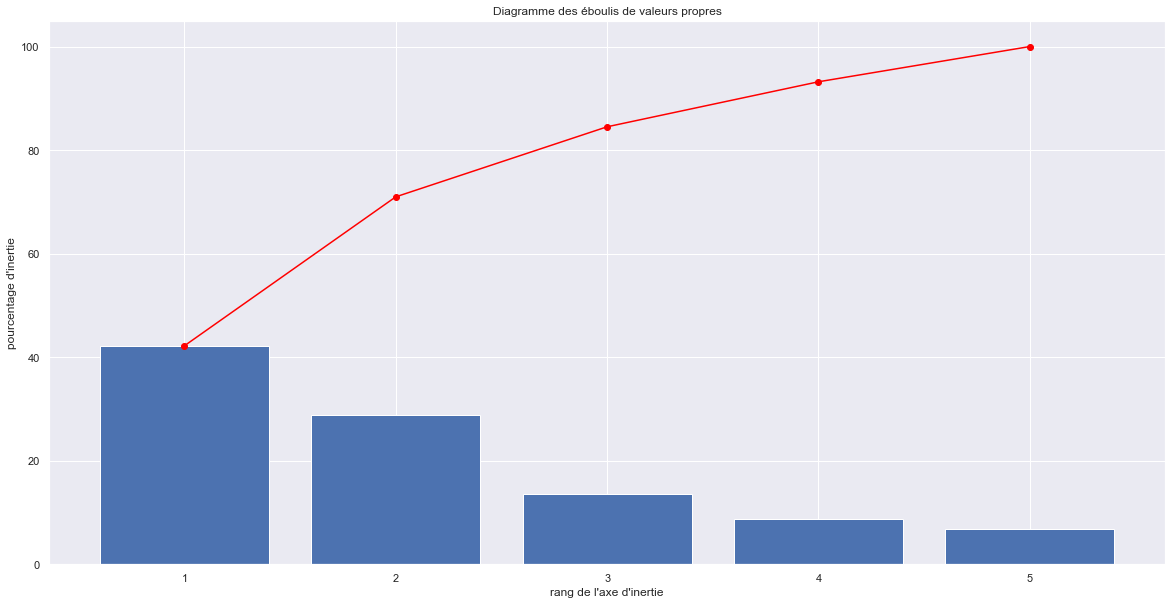

In [283]:
#Représentation de la variance expliquée: Diagramme des éboulis de valeurs propres avec somme cumulée
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(20,10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red',marker='o')
    
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Diagramme des éboulis de valeurs propres")

plt.savefig("p8_graphic/eboulis_valeurs_propres.png")
plt.show()

### Ce graphique nous montre bien qu'avec les 2 premiers rangs de l'inertie, nous conservons 71% de l'information. Nous allons donc afficher les pays selon le premier plan factoriel F1 et F2

In [284]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
        
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontsize=20)
            plt.savefig("p8_graphic/cercle_corr.png")
            plt.show(block=False)

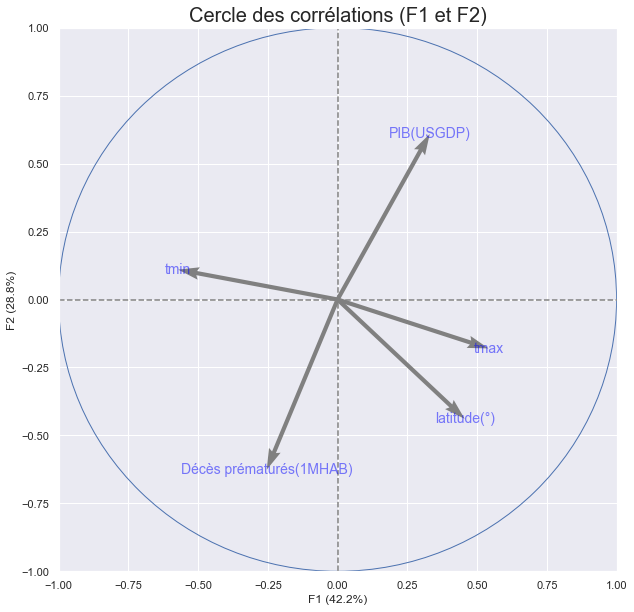

In [285]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

In [286]:
#Coefficients de la composante principale F1
F1 = pca.components_[0]
print(F1) 
#Coefficients de la composante principale F2
F2 = pca.components_[1]
print(F2)

[-0.25383797  0.45541373  0.33034584 -0.5713754   0.54089407]
[-0.62598602 -0.43904821  0.60903241  0.10997144 -0.1798999 ]


### Ces coefficients nous donne les variables qui composent F1 et F2, à savoir que:
### F1 est représenté par la latitude, les températures minimales et maximales
### F2 est représenté par les décès prématurés et le PIB
### Dans le cas présent, tmin est anti-corrélée à tmax et la latitude, et le PIB l'est avec "décès prématurés"

In [287]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(15,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()


            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='15', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) *1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=25)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=25)

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1), fontsize=25)
            plt.savefig("p8_graphic/proj_ind.png")
            plt.show(block=False)

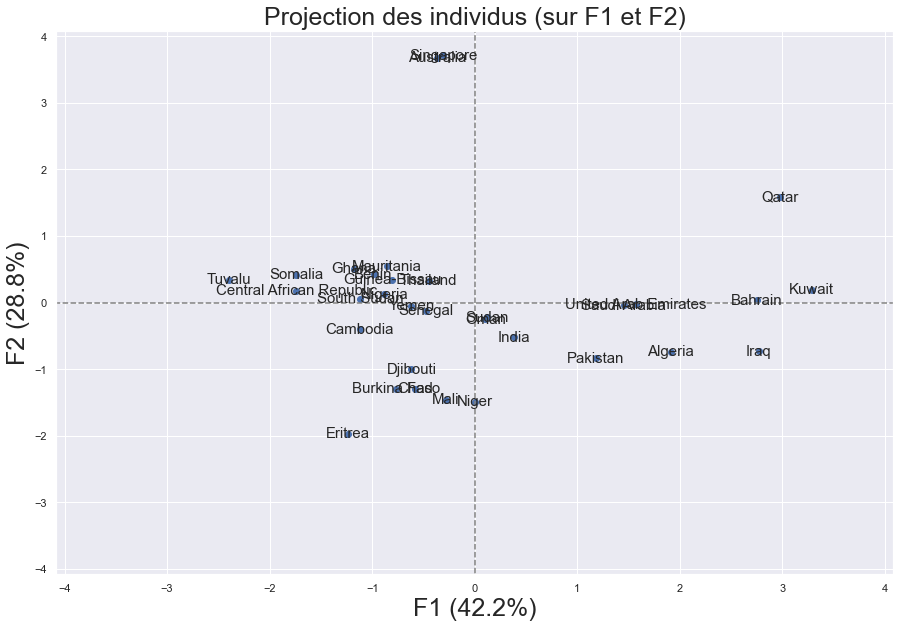

In [288]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca,[(0,1)] , labels = np.array(names))

### En s'aidant du cercle de corrélation tracée plus tôt, nous commençons déjà à avoir une idée des pays les plus affectés par les fortes températures. En effet, les pays situés le plus en bas compteront le plus de décès, et de plus seront moins riches, donc étant moins résilient aux différents risques.
### Les pays situés à droite du plan atteignent les températures maximales les plus élevées, ce qui représente un risque également. 

### Nous allons concrétiser cette idée en faisant un 2ème clustering, par K-Means cette fois

### Recherche du nombre optimal de clusters avec la "méthode du coude"

C:\Users\denis\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


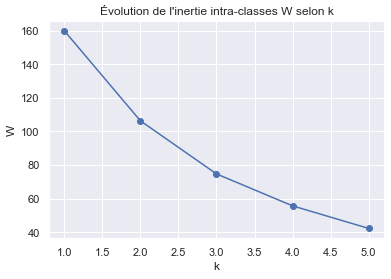

In [289]:
inerties=[]

#Boucle de 1 à 5 pour tester toutes ces possibilités
for k in range(1, 6):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(range(1, 6), inerties, marker='o')
plt.xlabel('k')
plt.ylabel('W')
plt.title("Évolution de l'inertie intra-classes W selon k")

plt.savefig("p8_graphic/kmeans_inertie.png")
plt.show()

### Il 

In [290]:
cls = cluster.KMeans(n_clusters=4)
cls.fit(X_scaled)

KMeans(n_clusters=4)

In [291]:
cls

KMeans(n_clusters=4)

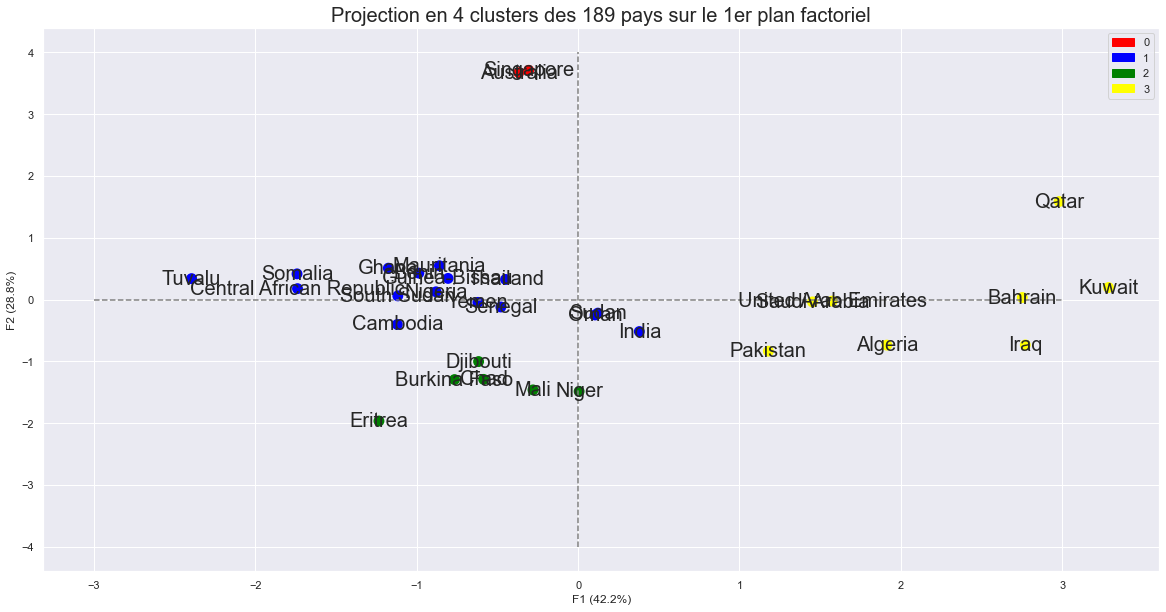

In [292]:
plt.figure(figsize=(20, 10))
centroids = cls.cluster_centers_
centroids_projected = pca.transform(centroids)
labels = np.array(names)

colormap = np.array(['red', 'blue', 'green', 'yellow'])

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[cls.predict(X_scaled)], 
           linewidths=1.4, s=90)
#plt.scatter(centroids_projected[:,0],centroids_projected[:,1], marker="*", c="black",
           # linewidths=1.4, s=150)


# affichage des lignes horizontales et verticales
plt.plot([-3, 3], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-4, 4], color='grey', ls='--')

for i,(x,y) in enumerate(X_projected[:,[0,1]]):
    plt.text(x, y, labels[i], fontsize='20', ha='center',va='center')

lab_0 = mpatches.Patch(color='red', label='0')
lab_1 = mpatches.Patch(color='blue', label='1')
lab_2 = mpatches.Patch(color='green', label='2')
lab_3 = mpatches.Patch(color='yellow', label='3')
#centroïde = mpatches.Patch(color='black', hatch="*", label='centroïde')
plt.legend(handles=[lab_0, lab_1, lab_2, lab_3])

plt.xlabel('F{} ({}%)'.format(1, round(scree[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(scree[1],1)))
plt.title("Projection en 4 clusters des 189 pays sur le 1er plan factoriel", fontsize=20)

plt.savefig("p8_graphic/projection_kmeans.png")
plt.show()

In [293]:
#Intégration des clusters dans notre dataframe "df_cls" par la méthode .concat()
df_cls = pd.DataFrame(cls.predict(X_scaled), columns=['cluster'])

In [294]:
data_cl3.reset_index(inplace=True)

In [295]:
df_cls = pd.concat([df_cls, data_cl3], axis=1)
df_cls

cluster                   Country  Décès prématurés(1MHAB)  latitude(°)  \
0         0                 Australia                   57.871       -35.15   
1         3                   Algeria                   76.747        36.42   
2         3                   Bahrain                   68.733        26.10   
3         1                     Benin                   81.501         6.23   
4         2              Burkina Faso                  165.721        12.15   
5         1  Central African Republic                  110.890         4.23   
6         2                      Chad                  165.317        12.10   
7         1                  Cambodia                  125.876        11.33   
8         2                  Djibouti                  153.506        11.08   
9         2                   Eritrea                  209.104        15.19   
10        1                     Ghana                   83.446         5.35   
11        1             Guinea-Bissau                   77.323        11.45   
12        1                     India                   93.120        28.37   
13        3                      Iraq                   72.472        33.20   
14        3                    Kuwait                   67.371        29.30   
15        2                      Mali                  168.774        12.34   
16        1                Mauritania                  106.509       -20.10   
17        2                     Niger                  165.037        13.27   
18        1                   Nigeria                   96.700         9.05   
19        1                      Oman                  114.109        23.37   
20        3                  Pakistan                   99.098        30.26   
21        3                     Qatar                   65.255        25.15   
22        1                   Senegal                   95.173        14.34   
23        0                 Singapore                   24.748         1.16   
24        3              Saudi Arabia                   98.270        23.53   
25        1                   Somalia                   98.105         2.02   
26        1                  Thailand                   85.901        13.45   
27        3      United Arab Emirates                  133.601        24.28   
28        1                    Tuvalu                  131.560        -8.31   
29        1                     Sudan                   90.954        15.31   
30        1                     Yemen                   95.649        15.33   
31        1               South Sudan                  100.865         7.51   

      PIB(USGDP)  tmin  tmax  
0   54763.202388  13.2  29.9  
1    3975.510381  10.9  34.1  
2   23503.977127  13.8  39.6  
3    1220.492825  24.9  31.9  
4     786.895614  22.9  33.9  
5     467.907246  23.0  28.4  
6     706.825833  18.9  32.7  
7    1643.641451  23.3  31.0  
8    3252.320409  22.7  34.1  
9     566.711679  20.3  31.1  
10   2202.629207  25.0  31.1  
11    688.351615  23.4  31.1  
12   2116.177386  16.3  31.1  
13   5729.677358   5.4  35.8  
14  31999.271891  10.0  39.0  
15    886.794271  19.4  34.6  
16   1677.917728  19.1  34.5  
17    554.579943  17.1  34.6  
18   2361.206967  23.2  31.5  
19  15343.062004  18.9  31.4  
20   1186.692080   7.3  30.4  
21  64781.733197  15.1  37.8  
22   1452.134664  23.3  32.8  
23  64102.737611  26.1  29.3  
24  23139.802114  13.7  34.3  
25    105.310682  24.8  29.3  
26   7784.739080  21.4  31.2  
27  43103.323058  16.5  35.7  
28   4036.000516  27.1  29.6  
29    815.060101  18.7  33.2  
30    855.066811  17.9  29.1  
31    448.355293  25.0  31.8

In [296]:
df_cls.groupby('cluster').mean()

Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)       tmin  \
cluster                                                                  
0                      41.309500   -16.995000  59432.969999  19.650000   
1                      99.230063     8.683125   2701.128348  22.206250   
2                     171.243167    12.688333   1125.687958  20.216667   
3                      85.193375    28.530000  24677.498401  11.587500   

            tmax  
cluster           
0        29.6000  
1        31.1875  
2        33.5000  
3        35.8375

In [297]:
df_cls.set_index('Country', inplace=True)

In [298]:
d1 = df_cls[df_cls.cluster==1]
d1

cluster  Décès prématurés(1MHAB)  latitude(°)  \
Country                                                                   
Benin                           1                   81.501         6.23   
Central African Republic        1                  110.890         4.23   
Cambodia                        1                  125.876        11.33   
Ghana                           1                   83.446         5.35   
Guinea-Bissau                   1                   77.323        11.45   
India                           1                   93.120        28.37   
Mauritania                      1                  106.509       -20.10   
Nigeria                         1                   96.700         9.05   
Oman                            1                  114.109        23.37   
Senegal                         1                   95.173        14.34   
Somalia                         1                   98.105         2.02   
Thailand                        1                   85.901        13.45   
Tuvalu                          1                  131.560        -8.31   
Sudan                           1                   90.954        15.31   
Yemen                           1                   95.649        15.33   
South Sudan                     1                  100.865         7.51   

                            PIB(USGDP)  tmin  tmax  
Country                                             
Benin                      1220.492825  24.9  31.9  
Central African Republic    467.907246  23.0  28.4  
Cambodia                   1643.641451  23.3  31.0  
Ghana                      2202.629207  25.0  31.1  
Guinea-Bissau               688.351615  23.4  31.1  
India                      2116.177386  16.3  31.1  
Mauritania                 1677.917728  19.1  34.5  
Nigeria                    2361.206967  23.2  31.5  
Oman                      15343.062004  18.9  31.4  
Senegal                    1452.134664  23.3  32.8  
Somalia                     105.310682  24.8  29.3  
Thailand                   7784.739080  21.4  31.2  
Tuvalu                     4036.000516  27.1  29.6  
Sudan                       815.060101  18.7  33.2  
Yemen                       855.066811  17.9  29.1  
South Sudan                 448.355293  25.0  31.8

In [300]:
d0 = df_cls[df_cls.cluster==0]
d0

cluster  Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)  tmin  \
Country                                                                        
Australia        0                   57.871       -35.15  54763.202388  13.2   
Singapore        0                   24.748         1.16  64102.737611  26.1   

           tmax  
Country          
Australia  29.9  
Singapore  29.3

In [301]:
d2 = df_cls[df_cls.cluster==2]
d2

cluster  Décès prématurés(1MHAB)  latitude(°)   PIB(USGDP)  \
Country                                                                    
Burkina Faso        2                  165.721        12.15   786.895614   
Chad                2                  165.317        12.10   706.825833   
Djibouti            2                  153.506        11.08  3252.320409   
Eritrea             2                  209.104        15.19   566.711679   
Mali                2                  168.774        12.34   886.794271   
Niger               2                  165.037        13.27   554.579943   

              tmin  tmax  
Country                   
Burkina Faso  22.9  33.9  
Chad          18.9  32.7  
Djibouti      22.7  34.1  
Eritrea       20.3  31.1  
Mali          19.4  34.6  
Niger         17.1  34.6

In [302]:
d3 = df_cls[df_cls.cluster==3]
d3

cluster  Décès prématurés(1MHAB)  latitude(°)  \
Country                                                               
Algeria                     3                   76.747        36.42   
Bahrain                     3                   68.733        26.10   
Iraq                        3                   72.472        33.20   
Kuwait                      3                   67.371        29.30   
Pakistan                    3                   99.098        30.26   
Qatar                       3                   65.255        25.15   
Saudi Arabia                3                   98.270        23.53   
United Arab Emirates        3                  133.601        24.28   

                        PIB(USGDP)  tmin  tmax  
Country                                         
Algeria                3975.510381  10.9  34.1  
Bahrain               23503.977127  13.8  39.6  
Iraq                   5729.677358   5.4  35.8  
Kuwait                31999.271891  10.0  39.0  
Pakistan               1186.692080   7.3  30.4  
Qatar                 64781.733197  15.1  37.8  
Saudi Arabia          23139.802114  13.7  34.3  
United Arab Emirates  43103.323058  16.5  35.7

In [303]:
d1.drop('cluster', axis=1, inplace=True)
d0.drop('cluster', axis=1, inplace=True)

C:\Users\denis\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [304]:
df_cls['danger'] = 0
for i,j in enumerate(df_cls['cluster']):
    if j == 3:
        df_cls['danger'][i]=4
    elif j == 2:
        df_cls['danger'][i]=2
    else:
        df_cls['danger'][i]=3

<ipython-input-304-5f5cd17b8474>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cls['danger'][i]=3
<ipython-input-304-5f5cd17b8474>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cls['danger'][i]=4
<ipython-input-304-5f5cd17b8474>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cls['danger'][i]=2


In [305]:
liste = list(df_cls.columns)
del liste[-1]

In [306]:
liste_2 = []
for col in liste:
    stat, p = shapiro(df_cls[col])
    if p > 0.05:#Si p>0.05, la variable est gaussienne
        liste_2.append(col)
    print(f'{col}:Statistics={round(stat, 3)}, p={round(p, 3)}')

cluster:Statistics=0.816, p=0.0
Décès prématurés(1MHAB):Statistics=0.943, p=0.089
latitude(°):Statistics=0.906, p=0.009
PIB(USGDP):Statistics=0.624, p=0.0
tmin:Statistics=0.939, p=0.068
tmax:Statistics=0.939, p=0.068


In [307]:
liste_2

['Décès prématurés(1MHAB)', 'tmin', 'tmax']

In [308]:
for col in liste_2:
    print(col,bartlett(d0[col],d1[col]))#Test de l'égalité des variances
    print(col,st.ttest_ind(d0[col],d1[col]))#Test de l'égalité des moyennes

Décès prématurés(1MHAB) BartlettResult(statistic=0.32334538975857086, pvalue=0.56960409033876)
Décès prématurés(1MHAB) Ttest_indResult(statistic=-4.835808902674282, pvalue=0.0001825169210622078)
tmin BartlettResult(statistic=3.0269387322534183, pvalue=0.0818923912218214)
tmin Ttest_indResult(statistic=-0.9006518171232551, pvalue=0.3811303418715484)
tmax BartlettResult(statistic=1.2441838241871512, pvalue=0.26466624977183534)
tmax Ttest_indResult(statistic=-1.3900811050640502, pvalue=0.1835418459126311)


In [309]:
for col in liste_2:
    print(col,bartlett(d0[col],d2[col]))#Test de l'égalité des variances
    print(col,st.ttest_ind(d0[col],d2[col]))#Test de l'égalité des moyennes

Décès prématurés(1MHAB) BartlettResult(statistic=0.05111988362587389, pvalue=0.8211259258651464)
Décès prématurés(1MHAB) Ttest_indResult(statistic=-7.945459730326296, pvalue=0.00021133235637737523)
tmin BartlettResult(statistic=3.5817053929322618, pvalue=0.058419148820808675)
tmin Ttest_indResult(statistic=-0.16306001110869398, pvalue=0.8758246444495318)
tmax BartlettResult(statistic=1.011770335420655, pvalue=0.3144790947100078)
tmax Ttest_indResult(statistic=-3.791991782780155, pvalue=0.009052244841872698)


In [310]:
for col in liste_2:
    print(col,bartlett(d1[col],d2[col]))#Test de l'égalité des variances
    print(col,st.ttest_ind(d1[col],d2[col]))#Test de l'égalité des moyennes

Décès prématurés(1MHAB) BartlettResult(statistic=0.3907754445403785, pvalue=0.531892076630437)
Décès prématurés(1MHAB) Ttest_indResult(statistic=-9.163125902444728, pvalue=1.3468484798180078e-08)
tmin BartlettResult(statistic=0.6504413858716763, pvalue=0.419954916796042)
tmin Ttest_indResult(statistic=1.419624761293177, pvalue=0.17111660600338)
tmax BartlettResult(statistic=0.12679526929232762, pvalue=0.7217782330124569)
tmax Ttest_indResult(statistic=-3.176361596636301, pvalue=0.0047452648710144835)


In [311]:
df_cls.reset_index(inplace=True)
#df_cls['cluster'] = df_cls['cluster'] + 3

In [312]:
data_clfinal = df_cls[['Country','cluster', 'danger']]
#data_clfinal.reset_index(inplace=True)

In [313]:
data_clfinal

Country  cluster  danger
0                  Australia        0       3
1                    Algeria        3       4
2                    Bahrain        3       4
3                      Benin        1       3
4               Burkina Faso        2       2
5   Central African Republic        1       3
6                       Chad        2       2
7                   Cambodia        1       3
8                   Djibouti        2       2
9                    Eritrea        2       2
10                     Ghana        1       3
11             Guinea-Bissau        1       3
12                     India        1       3
13                      Iraq        3       4
14                    Kuwait        3       4
15                      Mali        2       2
16                Mauritania        1       3
17                     Niger        2       2
18                   Nigeria        1       3
19                      Oman        1       3
20                  Pakistan        3       4
21                     Qatar        3       4
22                   Senegal        1       3
23                 Singapore        0       3
24              Saudi Arabia        3       4
25                   Somalia        1       3
26                  Thailand        1       3
27      United Arab Emirates        3       4
28                    Tuvalu        1       3
29                     Sudan        1       3
30                     Yemen        1       3
31               South Sudan        1       3

In [314]:
data_df['danger'] = data_df['cluster']

In [315]:
data_df = data_df.merge(data_clfinal, on='Country',how='left')
data_df

COU           Pays  Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)  \
0    AUS      Australie                   57.871       -35.15  54763.202388   
1    AFG    Afghanistan                   27.718        34.28    469.919090   
2    ALB        Albanie                    0.355        41.18   5303.197823   
3    DZA        Algérie                   76.747        36.42   3975.510381   
4    AND        Andorre                    0.012        42.31  40887.421647   
..   ...            ...                      ...          ...           ...   
184  TUN        Tunisie                   27.747        36.50   3317.515276   
185  VNM       Viet Nam                   44.142        21.05   2715.275874   
186  YEM          Yémen                   95.649        15.33    855.066811   
187  MNE     MontTnTgro                    0.388        42.42   8825.344514   
188  SSD  Soudan du Sud                  100.865         7.51    448.355293   

     Population      Country  tmin  tmax  Décès prématurés par année  \
0      25365745    Australia  13.2  29.9                        1468   
1      38041757  Afghanistan  -4.0  27.1                        1055   
2       2854191      Albania  -0.6  23.6                           2   
3      43053054      Algeria  10.9  34.1                        3305   
4         77146      Andorra  -2.1  20.6                           1   
..          ...          ...   ...   ...                         ...   
184    11694721      Tunisia   8.7  32.1                         325   
185    96462108     Viet Nam  18.4  28.5                        4259   
186    29161922        Yemen  17.9  29.1                        2790   
187      622028   Montenegro  -4.8  21.6                           1   
188    11062114  South Sudan  25.0  31.8                        1116   

     cluster_x  danger_x  cluster_y  danger_y  
0            2         2        0.0       3.0  
1            1         1        NaN       NaN  
2            1         1        NaN       NaN  
3            2         2        3.0       4.0  
4            1         1        NaN       NaN  
..         ...       ...        ...       ...  
184          1         1        NaN       NaN  
185          3         3        NaN       NaN  
186          2         2        1.0       3.0  
187          1         1        NaN       NaN  
188          2         2        1.0       3.0  

[189 rows x 14 columns]

In [316]:
data_df.fillna(0, inplace=True)

In [317]:
data_df['danger_y'] = data_df['danger_y'].astype(int)

In [318]:
data_df['danger'] = data_df['danger_x'] + data_df['danger_y'] 
data_df

COU           Pays  Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)  \
0    AUS      Australie                   57.871       -35.15  54763.202388   
1    AFG    Afghanistan                   27.718        34.28    469.919090   
2    ALB        Albanie                    0.355        41.18   5303.197823   
3    DZA        Algérie                   76.747        36.42   3975.510381   
4    AND        Andorre                    0.012        42.31  40887.421647   
..   ...            ...                      ...          ...           ...   
184  TUN        Tunisie                   27.747        36.50   3317.515276   
185  VNM       Viet Nam                   44.142        21.05   2715.275874   
186  YEM          Yémen                   95.649        15.33    855.066811   
187  MNE     MontTnTgro                    0.388        42.42   8825.344514   
188  SSD  Soudan du Sud                  100.865         7.51    448.355293   

     Population      Country  tmin  tmax  Décès prématurés par année  \
0      25365745    Australia  13.2  29.9                        1468   
1      38041757  Afghanistan  -4.0  27.1                        1055   
2       2854191      Albania  -0.6  23.6                           2   
3      43053054      Algeria  10.9  34.1                        3305   
4         77146      Andorra  -2.1  20.6                           1   
..          ...          ...   ...   ...                         ...   
184    11694721      Tunisia   8.7  32.1                         325   
185    96462108     Viet Nam  18.4  28.5                        4259   
186    29161922        Yemen  17.9  29.1                        2790   
187      622028   Montenegro  -4.8  21.6                           1   
188    11062114  South Sudan  25.0  31.8                        1116   

     cluster_x  danger_x  cluster_y  danger_y  danger  
0            2         2        0.0         3       5  
1            1         1        0.0         0       1  
2            1         1        0.0         0       1  
3            2         2        3.0         4       6  
4            1         1        0.0         0       1  
..         ...       ...        ...       ...     ...  
184          1         1        0.0         0       1  
185          3         3        0.0         0       3  
186          2         2        1.0         3       5  
187          1         1        0.0         0       1  
188          2         2        1.0         3       5  

[189 rows x 15 columns]

In [319]:
px.choropleth(data_df, locations='COU', hover_data=data_df.columns, color='danger', height=500)


In [320]:
data_dec = data_df[['Country', 'Décès prématurés par année']]
zte = data_dec.sort_values('Décès prématurés par année', ascending=False).head(15)

In [321]:
zte

Country  Décès prématurés par année
74          India                      127241
124      Pakistan                       21462
119       Nigeria                       19434
35          China                       13664
12     Bangladesh                        8949
21         Brazil                        6374
160      Thailand                        5981
80      Indonesia                        5574
46          Egypt                        5500
125   Philippines                        5178
185      Viet Nam                        4259
174         Sudan                        3895
112         Niger                        3848
146  Saudi Arabia                        3368
26   Burkina Faso                        3368

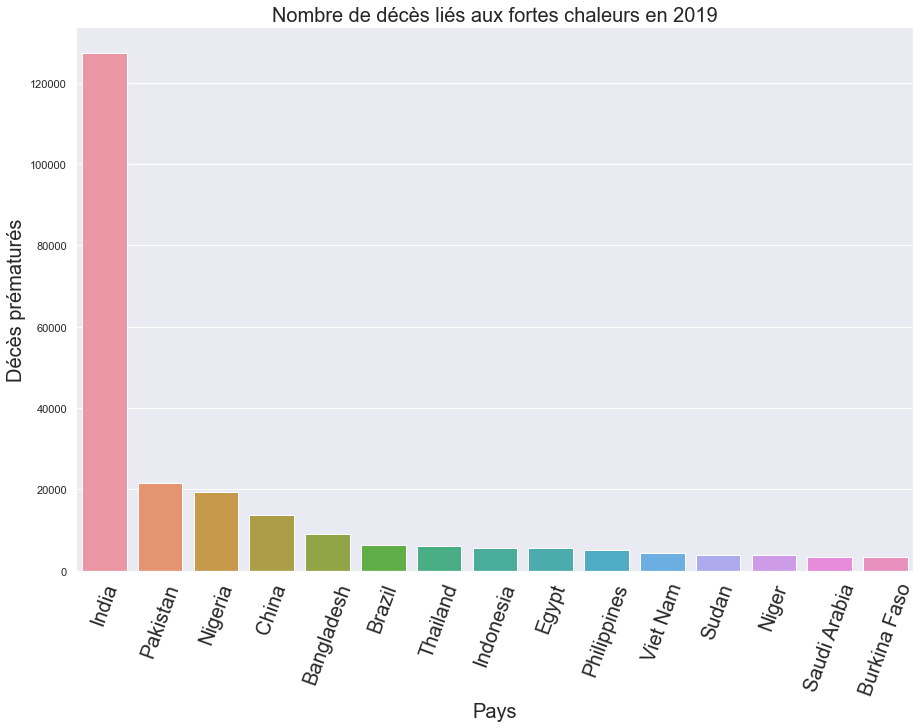

In [322]:
plt.figure(figsize=(15,10))
sns.barplot(data=zte, x='Country', y='Décès prématurés par année')
plt.xticks(rotation=70, fontsize=20)
plt.xlabel('Pays', fontsize=20)
plt.ylabel('Décès prématurés', fontsize = 20)
plt.title('Nombre de décès liés aux fortes chaleurs en 2019', fontsize=20)
plt.savefig('p8_graphic/barplot')
plt.show()

In [323]:
a = data_dec['Décès prématurés par année'].sum()

In [324]:
a

307879

In [325]:
b = a/365/24/3600

In [326]:
b

0.009762779046169456

In [327]:
1/b

102.429850688095

In [328]:
127241/a*100

41.32824908486776

In [329]:
data_df

COU           Pays  Décès prématurés(1MHAB)  latitude(°)    PIB(USGDP)  \
0    AUS      Australie                   57.871       -35.15  54763.202388   
1    AFG    Afghanistan                   27.718        34.28    469.919090   
2    ALB        Albanie                    0.355        41.18   5303.197823   
3    DZA        Algérie                   76.747        36.42   3975.510381   
4    AND        Andorre                    0.012        42.31  40887.421647   
..   ...            ...                      ...          ...           ...   
184  TUN        Tunisie                   27.747        36.50   3317.515276   
185  VNM       Viet Nam                   44.142        21.05   2715.275874   
186  YEM          Yémen                   95.649        15.33    855.066811   
187  MNE     MontTnTgro                    0.388        42.42   8825.344514   
188  SSD  Soudan du Sud                  100.865         7.51    448.355293   

     Population      Country  tmin  tmax  Décès prématurés par année  \
0      25365745    Australia  13.2  29.9                        1468   
1      38041757  Afghanistan  -4.0  27.1                        1055   
2       2854191      Albania  -0.6  23.6                           2   
3      43053054      Algeria  10.9  34.1                        3305   
4         77146      Andorra  -2.1  20.6                           1   
..          ...          ...   ...   ...                         ...   
184    11694721      Tunisia   8.7  32.1                         325   
185    96462108     Viet Nam  18.4  28.5                        4259   
186    29161922        Yemen  17.9  29.1                        2790   
187      622028   Montenegro  -4.8  21.6                           1   
188    11062114  South Sudan  25.0  31.8                        1116   

     cluster_x  danger_x  cluster_y  danger_y  danger  
0            2         2        0.0         3       5  
1            1         1        0.0         0       1  
2            1         1        0.0         0       1  
3            2         2        3.0         4       6  
4            1         1        0.0         0       1  
..         ...       ...        ...       ...     ...  
184          1         1        0.0         0       1  
185          3         3        0.0         0       3  
186          2         2        1.0         3       5  
187          1         1        0.0         0       1  
188          2         2        1.0         3       5  

[189 rows x 15 columns]

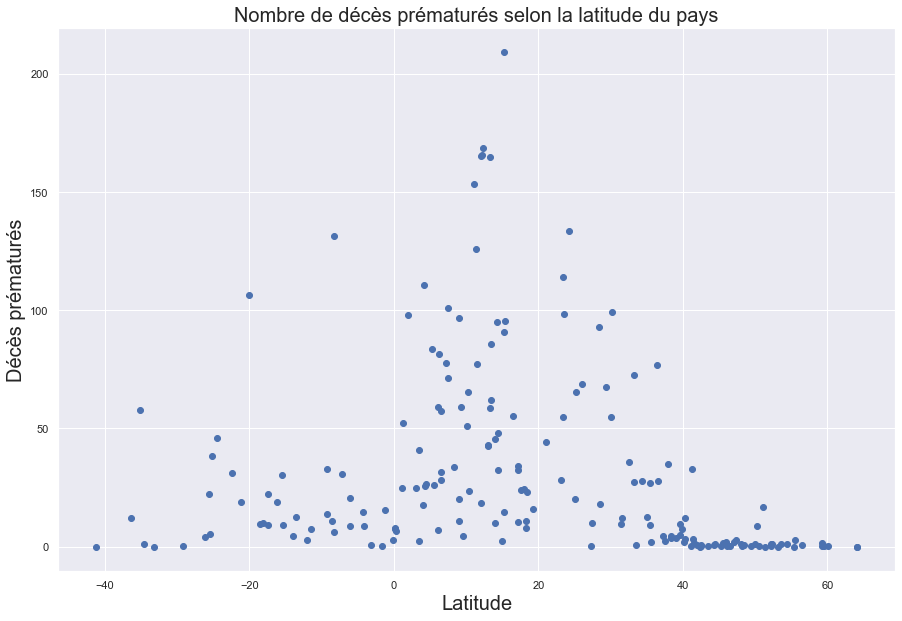

In [330]:
plt.figure(figsize=(15,10))

plt.scatter(data_df['latitude(°)'], data_df['Décès prématurés(1MHAB)'])
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Décès prématurés', fontsize=20)
plt.title('Nombre de décès prématurés selon la latitude du pays', fontsize=20)
plt.savefig('p8_graphic/dec_lat.png')
plt.show()

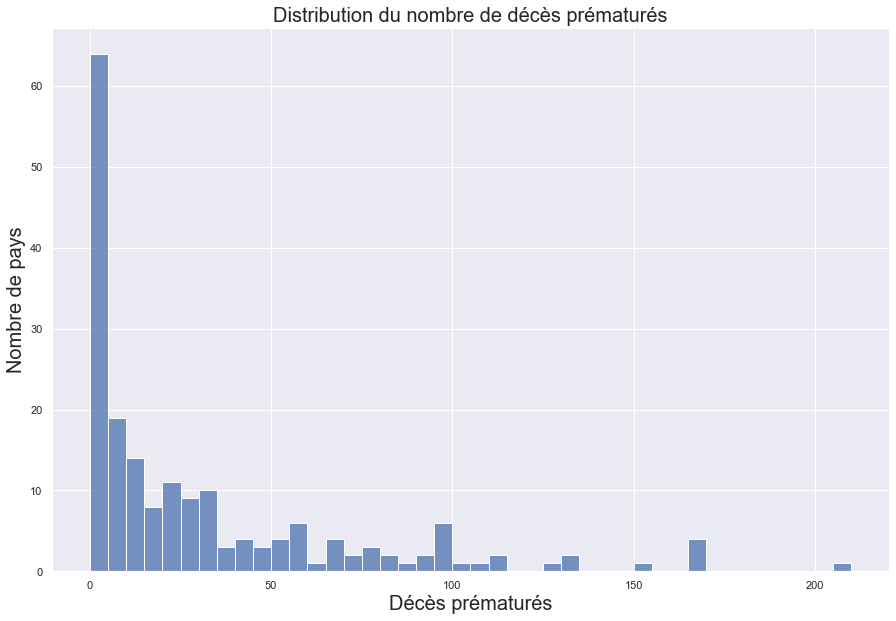

In [331]:
plt.figure(figsize=(15,10))
sns.histplot(data=data_df, x='Décès prématurés(1MHAB)', binwidth=5)
plt.xlabel('Décès prématurés', fontsize=20)
plt.ylabel('Nombre de pays', fontsize=20)
plt.title('Distribution du nombre de décès prématurés', fontsize=20)
plt.savefig('p8_graphic/distrib_dec.png')

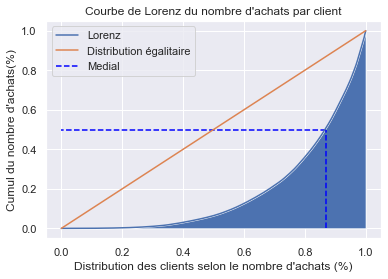

In [332]:
transaction = data_df['Décès prématurés(1MHAB)'].values
lorenz_nb = np.cumsum(np.sort(transaction)) / transaction.sum()

plt.plot(np.linspace(0,1,len(lorenz_nb)), lorenz_nb,  label='Lorenz')
plt.fill_between(np.linspace(0,1,len(lorenz_nb)) ,lorenz_nb )
plt.plot([0, 1], [0, 1],  label='Distribution égalitaire')
plt.vlines(x=.87, ymin=0, ymax=.5, color='blue', linestyle='--', label='Medial')
plt.hlines(xmin=.87, xmax=0, y=.5, color='blue', linestyle='--')

plt.title("Courbe de Lorenz du nombre d'achats par client")
plt.xlabel("Distribution des clients selon le nombre d'achats (%)")
plt.ylabel("Cumul du nombre d'achats(%)")
plt.legend()


plt.show()

In [333]:
data_df[data_df['Décès prématurés(1MHAB)'] < 50]

COU                Pays  Décès prématurés(1MHAB)  latitude(°)  \
1    AFG         Afghanistan                   27.718        34.28   
2    ALB             Albanie                    0.355        41.18   
4    AND             Andorre                    0.012        42.31   
5    AGO              Angola                   10.956        -8.50   
6    ATG  Antigua-et-Barbuda                   10.388        17.20   
..   ...                 ...                      ...          ...   
182  SRB              Serbie                    0.913        44.50   
183  TUR             Turquie                    4.953        39.57   
184  TUN             Tunisie                   27.747        36.50   
185  VNM            Viet Nam                   44.142        21.05   
187  MNE          MontTnTgro                    0.388        42.42   

       PIB(USGDP)  Population              Country  tmin  tmax  \
1      469.919090    38041757          Afghanistan  -4.0  27.1   
2     5303.197823     2854191              Albania  -0.6  23.6   
4    40887.421647       77146              Andorra  -2.1  20.6   
5     2670.850732    31825299               Angola  18.0  24.4   
6    17112.821135       97115  Antigua and Barbuda  24.3  28.3   
..            ...         ...                  ...   ...   ...   
182   7359.348533     6945235               Serbia  -4.8  23.9   
183   9126.562459    83429607               Turkey  -3.5  24.6   
184   3317.515276    11694721              Tunisia   8.7  32.1   
185   2715.275874    96462108             Viet Nam  18.4  28.5   
187   8825.344514      622028           Montenegro  -4.8  21.6   

     Décès prématurés par année  cluster_x  danger_x  cluster_y  danger_y  \
1                          1055          1         1        0.0         0   
2                             2          1         1        0.0         0   
4                             1          1         1        0.0         0   
5                           349          3         3        0.0         0   
6                             2          3         3        0.0         0   
..                          ...        ...       ...        ...       ...   
182                           7          1         1        0.0         0   
183                         414          1         1        0.0         0   
184                         325          1         1        0.0         0   
185                        4259          3         3        0.0         0   
187                           1          1         1        0.0         0   

     danger  
1         1  
2         1  
4         1  
5         3  
6         3  
..      ...  
182       1  
183       1  
184       1  
185       3  
187       1  

[145 rows x 15 columns]

In [334]:
test = data_df.sort_values('Décès prématurés(1MHAB)', ascending=False)

In [335]:
s = 0
for i,j in enumerate(test['Décès prématurés(1MHAB)']):
    s = s+j
    if s > 200:
        break
print(i)

0


In [336]:
test.head(11)

COU                       Pays  Décès prématurés(1MHAB)  latitude(°)  \
57   ERI                   Érythrée                  209.104        15.19   
107  MLI                       Mali                  168.774        12.34   
26   BFA               Burkina Faso                  165.721        12.15   
31   TCD                      Tchad                  165.317        12.10   
112  NER                      Niger                  165.037        13.27   
49   DJI                   Djibouti                  153.506        11.08   
164  ARE        Émirats arabes unis                  133.601        24.28   
170  TUV                     Tuvalu                  131.560        -8.31   
33   KHM                   Cambodge                  125.876        11.33   
123  OMN                       Oman                  114.109        23.37   
30   CAF  République centrafricaine                  110.890         4.23   

       PIB(USGDP)  Population                   Country  tmin  tmax  \
57     566.711679     6081000                   Eritrea  20.3  31.1   
107    886.794271    19658023                      Mali  19.4  34.6   
26     786.895614    20321383              Burkina Faso  22.9  33.9   
31     706.825833    15946882                      Chad  18.9  32.7   
112    554.579943    23310719                     Niger  17.1  34.6   
49    3252.320409      973557                  Djibouti  22.7  34.1   
164  43103.323058     9770526      United Arab Emirates  16.5  35.7   
170   4036.000516       11655                    Tuvalu  27.1  29.6   
33    1643.641451    16486542                  Cambodia  23.3  31.0   
123  15343.062004     4974992                      Oman  18.9  31.4   
30     467.907246     4745179  Central African Republic  23.0  28.4   

     Décès prématurés par année  cluster_x  danger_x  cluster_y  danger_y  \
57                         1272          2         2        2.0         2   
107                        3318          2         2        2.0         2   
26                         3368          2         2        2.0         2   
31                         2637          2         2        2.0         2   
112                        3848          2         2        2.0         2   
49                          150          2         2        2.0         2   
164                        1306          2         2        3.0         4   
170                           2          2         2        1.0         3   
33                         2076          2         2        1.0         3   
123                         568          2         2        1.0         3   
30                          527          2         2        1.0         3   

     danger  
57        4  
107       4  
26        4  
31        4  
112       4  
49        4  
164       6  
170       5  
33        5  
123       5  
30        5

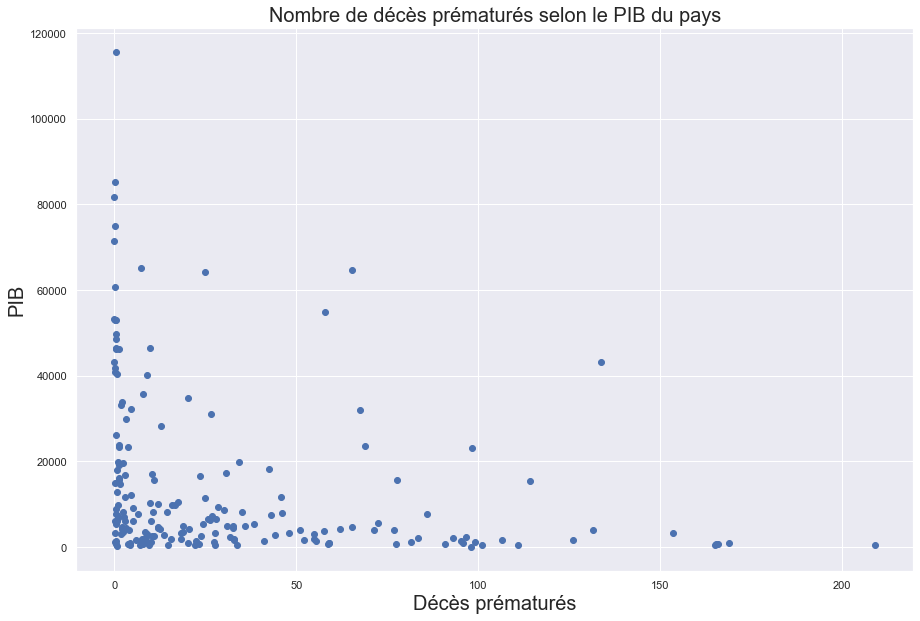

In [337]:
plt.figure(figsize=(15,10))

plt.scatter(data_df['Décès prématurés(1MHAB)'],data_df['PIB(USGDP)'])
plt.ylabel('PIB', fontsize=20)
plt.xlabel('Décès prématurés', fontsize=20)
plt.title('Nombre de décès prématurés selon le PIB du pays', fontsize=20)
plt.savefig('p8_graphic/dec_pib.png')
plt.show()

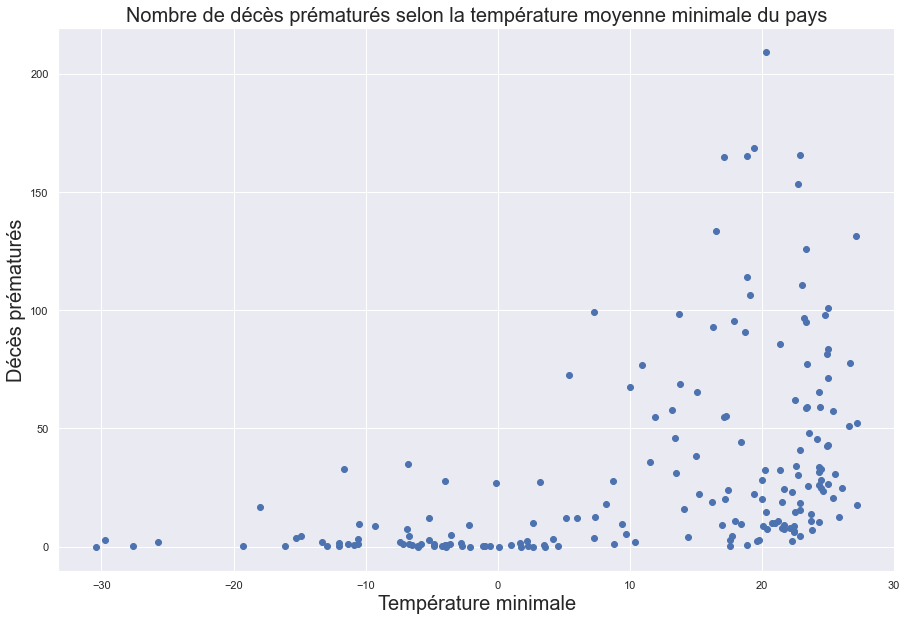

In [338]:
plt.figure(figsize=(15,10))

plt.scatter(data_df['tmin'], data_df['Décès prématurés(1MHAB)'])
plt.xlabel('Température minimale', fontsize=20)
plt.ylabel('Décès prématurés', fontsize=20)
plt.title('Nombre de décès prématurés selon la température moyenne minimale du pays', fontsize=20)
plt.savefig('p8_graphic/dec_tmin.png')
plt.show()

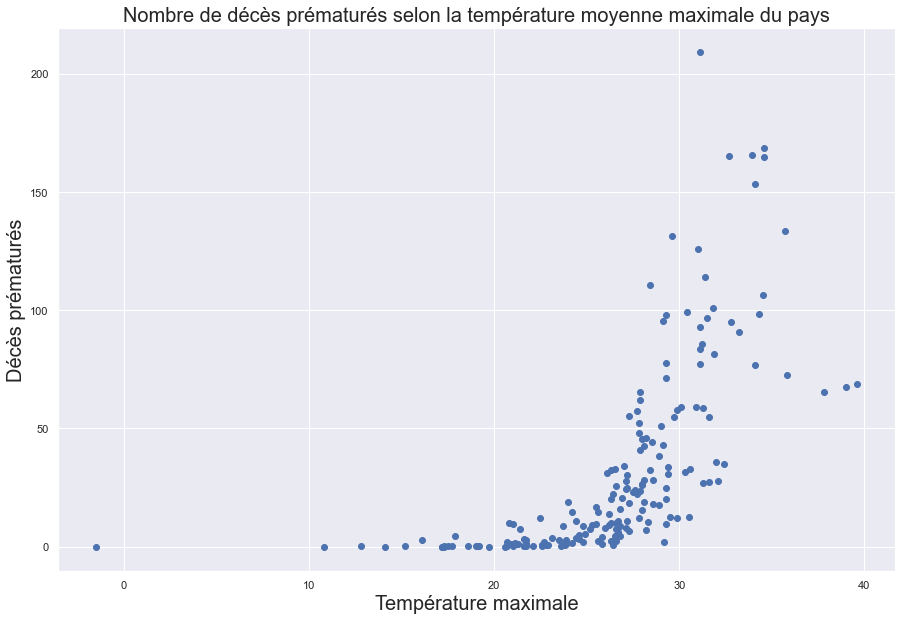

In [339]:
plt.figure(figsize=(15,10))

plt.scatter(data_df['tmax'], data_df['Décès prématurés(1MHAB)'])
plt.xlabel('Température maximale', fontsize=20)
plt.ylabel('Décès prématurés', fontsize=20)
plt.title('Nombre de décès prématurés selon la température moyenne maximale du pays', fontsize=20)
plt.savefig('p8_graphic/dec_tmax.png')
plt.show()